# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* **Pytorch Version** 



<a id='1.3'></a>
## 2.3. Import Packages

In [7]:
import sys
import warnings
warnings.filterwarnings('ignore')
import talib as ta
from utils import process_future_data, dates_intersection, add_covariance, StockPortfolioEnv, create_features
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

sys.path.append("../FinRL-Library")

<a id='1.4'></a>
## 2.4. Create Folders

In [8]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [9]:
stocks_br  = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "MGLU3.SA", "BBAS3.SA", "BBDC4.SA","B3SA3.SA", "PETR3.SA", "RENT3.SA", "ELET3.SA" ]
stocks_usa = ["META", "AAPL", "AMZN", "F", "T", "BAC", "GOOGL", "MSFT", "INTC", "CMCSA"]
stocks_eur = ["iSP.MI", "ENEL.MI", "SAN.MC", "INGA.AS", "ENI.MI", "BBVA.MC", "IBE.MC", "CS.PA", "STLA.MI","DTE.DE"]
stocks_chn = ["601899.SS","600010.SS","600795.SS", "603993.SS", "600157.SS", "601288.SS", "600050.SS", "601398.SS", "600537.SS","600777.SS"]

In [10]:
ativos = list(set().union(stocks_br,stocks_usa,stocks_eur,stocks_chn))

In [11]:
dp = YahooFinanceProcessor()
df = dp.download_data(start_date = '2004-01-01',
                     end_date = '2022-11-07',
                     ticker_list = ativos, time_interval='1D')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [12]:
df['date']= pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

## Add covariance matrix as states

In [13]:
df = add_covariance(df)

## Adding Features

In [14]:
df = create_features(df)

In [15]:
dates_f3 = dates_intersection(df)
print(df.shape)
df=df[df['date'].isin(dates_f3)]
print(df.shape)

(164863, 21)
(61920, 21)


In [16]:
#df['tic'].value_counts()

In [17]:
df.shape

(61920, 21)

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


In [18]:
print(df.date.head(1))
print(df.date.tail(1))

69998   2013-01-04
Name: date, dtype: datetime64[ns]
167230   2022-11-04
Name: date, dtype: datetime64[ns]


## Training data split: 2009-01-01 to 2020-07-01

In [19]:
train = data_split(df, '2013-01-04','2018-01-01')
trade = data_split(df,'2018-01-02', '2022-10-27')

In [20]:
train.head(1)

,date,open,high,low,close,adjcp,volume,tic,day,cov_list,...,RSI,slowk,slowd,WILLR,MACD,ROC,OBV,lag_20,lag_40,lag_60
0,2013-01-04,1.975,1.985714,1.928571,1.942857,1.899315,214400818.0,600010.SS,4,"[[0.0007838344569130898, 8.9325805536516e-05, ...",...,59.497655,53.365166,49.616944,-23.863621,0.03241,3.03031,6.781635e+10,0.182609,-0.003663,0.04817


In [21]:
train.tail(1)

,date,open,high,low,close,adjcp,volume,tic,day,cov_list,...,RSI,slowk,slowd,WILLR,MACD,ROC,OBV,lag_20,lag_40,lag_60
648,2017-11-21,2.762,2.798,2.752,2.768,1.722486,65018462.0,iSP.MI,1,"[[0.00026312101057223943, 3.700946382893613e-0...",...,26.27676,32.096751,36.486933,-82.432578,-0.031647,-2.877194,6.515216e+09,-0.046175,-0.069267,-0.015647


## Environment for Portfolio Allocation
##### Got from utils.py 

In [22]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 40, State Space: 40


In [23]:
features =['RSI', 'slowk', 'slowd', 'WILLR', 'MACD','ROC', 'OBV', 'lag_20', 'lag_40', 'lag_60']

In [24]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": features, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [25]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# <a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [26]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [27]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [28]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c',total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 330       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -56.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 2.72e+08  |
|    reward             | 1631889.1 |
|    std                | 0.998     |
|    value_loss         | 2.68e+13  |
-------------------------------------
begin_total_asset:1000000
end_total_asset:2215289.2565414715
Sharpe:  1.3091136270382084
-------------------------------------
| time/                 |           |
|    fps                | 426       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -56.7     |

In [29]:
trained_a2c.save('trained_models/trained_a2c.zip')
#trained_a2c = model_a2c.load('trained_models/trained_a2c.zip')

### Model 2: **PPO**


In [30]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [31]:
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo',total_timesteps=80000)

begin_total_asset:1000000
end_total_asset:2277213.4034864246
Sharpe:  1.3212103166664606
begin_total_asset:1000000
end_total_asset:2421714.4659634996
Sharpe:  1.3257952845390732
begin_total_asset:1000000
end_total_asset:2077113.4287555441
Sharpe:  1.3056278552721203
---------------------------------
| time/              |          |
|    fps             | 501      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 932844.3 |
---------------------------------
begin_total_asset:1000000
end_total_asset:2310784.4710615766
Sharpe:  1.3286827884579282
begin_total_asset:1000000
end_total_asset:2594202.854248545
Sharpe:  1.3818863824171377
begin_total_asset:1000000
end_total_asset:2404717.150816432
Sharpe:  1.3707370986062368
---------------------------------------
| time/                   |           |
|    fps                  | 535       |
|    iterations           | 2         |
| 

In [32]:
trained_ppo.save('trained_models/trained_ppo.zip')
#trained_ppo = model_ppo.load('trained_models/trained_ppo.zip')

### Model 3: **DDPG**


In [33]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [34]:
trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg',total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:2200267.754061932
Sharpe:  1.3222579829781707
begin_total_asset:1000000
end_total_asset:2155519.514391767
Sharpe:  1.2889341100882705
begin_total_asset:1000000
end_total_asset:2155519.514391767
Sharpe:  1.2889341100882705
begin_total_asset:1000000
end_total_asset:2155519.514391767
Sharpe:  1.2889341100882705
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 22        |
|    time_elapsed    | 117       |
|    total_timesteps | 2596      |
| train/             |           |
|    actor_loss      | 2.51e+08  |
|    critic_loss     | 1.22e+14  |
|    learning_rate   | 0.001     |
|    n_updates       | 1947      |
|    reward          | 2155519.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2155519.514391767
Sharpe:  1.2889341100882705
begin_total_asset:1000000
end_total_asset:2155519.514391767
Sharpe:  1.2889341100882705
begin_total_asset

In [35]:
trained_ddpg.save('trained_models/trained_ddpg.zip')
#trained_ddpg = model_ddpg.load('trained_models/trained_ddpg.zip')

### Model 4: **SAC**


In [36]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [37]:
trained_sac = agent.train_model(model=model_sac, tb_log_name='sac',total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:2349510.442006011
Sharpe:  1.277419518764455
begin_total_asset:1000000
end_total_asset:2271302.756661653
Sharpe:  1.2302444309662193
begin_total_asset:1000000
end_total_asset:2271302.756661653
Sharpe:  1.2302444309662193
begin_total_asset:1000000
end_total_asset:2271302.756661653
Sharpe:  1.2302444309662193
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 15        |
|    time_elapsed    | 172       |
|    total_timesteps | 2596      |
| train/             |           |
|    actor_loss      | -2.86e+08 |
|    critic_loss     | 1.11e+14  |
|    ent_coef        | 0.212     |
|    ent_coef_loss   | 1.44e+03  |
|    learning_rate   | 0.0003    |
|    n_updates       | 2495      |
|    reward          | 2271302.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2271302.756661653
Sharpe:  1.2302444309662193
begin_total_asset:1000000
end_total_

In [38]:
trained_sac.save('trained_models/trained_sac.zip')
#trained_sac = model_sac.load('trained_models/trained_sac.zip')

### Model 5: **TD3**


In [39]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [40]:
trained_td3 = agent.train_model(model=model_td3, tb_log_name='td3',total_timesteps=30000)

begin_total_asset:1000000
end_total_asset:2400576.2465894856
Sharpe:  1.4687290382180627
begin_total_asset:1000000
end_total_asset:2444194.384355381
Sharpe:  1.4949844027832002
begin_total_asset:1000000
end_total_asset:2444194.384355381
Sharpe:  1.4949844027832002
begin_total_asset:1000000
end_total_asset:2444194.384355381
Sharpe:  1.4949844027832002
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 24        |
|    time_elapsed    | 104       |
|    total_timesteps | 2596      |
| train/             |           |
|    actor_loss      | 1.19e+08  |
|    critic_loss     | 1.12e+14  |
|    learning_rate   | 0.001     |
|    n_updates       | 1947      |
|    reward          | 2444194.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2444194.384355381
Sharpe:  1.4949844027832002
begin_total_asset:1000000
end_total_asset:2444194.384355381
Sharpe:  1.4949844027832002
begin_total_asse

In [41]:
trained_td3.save('trained_models/trained_td3.zip')
#trained_td3 = model_td3.load('trained_models/trained_td3.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [42]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [43]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c
#trained_td3

df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

df_daily_return2, df_actions2 = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)

df_daily_return3, df_actions3 = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

df_daily_return4, df_actions4 = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

df_daily_return5, df_actions5 = DRLAgent.DRL_prediction(model=trained_td3,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1373205.1666690374
Sharpe:  0.531402577522418
hit end!
begin_total_asset:1000000
end_total_asset:1361783.9652077956
Sharpe:  0.5077658843900005
hit end!
begin_total_asset:1000000
end_total_asset:1355425.3550781254
Sharpe:  0.5169727143502165
hit end!
begin_total_asset:1000000
end_total_asset:1285632.2567256186
Sharpe:  0.4401677186926004
hit end!
begin_total_asset:1000000
end_total_asset:1302562.9849621418
Sharpe:  0.4547773881203434
hit end!


In [44]:
df_daily_return.to_csv('results/df_daily_return_sac.csv')
df_daily_return2.to_csv('results/df_daily_return_ddpg.csv')
df_daily_return3.to_csv('results/df_daily_return_ppo.csv')
df_daily_return4.to_csv('results/df_daily_return_a2c.csv')
df_daily_return5.to_csv('results/df_daily_return_td3.csv')

In [45]:
df_actions.to_csv( 'results/df_actions_sac.csv')
df_actions2.to_csv('results/df_actions_ddpg.csv')
df_actions3.to_csv('results/df_actions_ppo.csv')
df_actions4.to_csv('results/df_actions_a2c.csv')
df_actions5.to_csv('results/df_actions_td3.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [46]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [47]:
import pyfolio as pf

Start date,2018-05-10
End date,2022-10-26
Total months,42
,Backtest
Annual return,9.362%
Cumulative returns,37.321%
Annual volatility,21.038%
Sharpe ratio,0.53
Calmar ratio,0.26
Stability,0.69
Max drawdown,-35.782%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.78,2020-01-07,2020-03-23,2020-11-23,230
1,14.71,2021-09-13,2022-07-14,NaT,NaN
2,14.54,2018-05-10,2018-06-27,2019-02-14,201
3,7.10,2019-04-23,2019-05-13,2019-10-28,135
4,6.59,2021-01-08,2021-01-29,2021-03-04,40


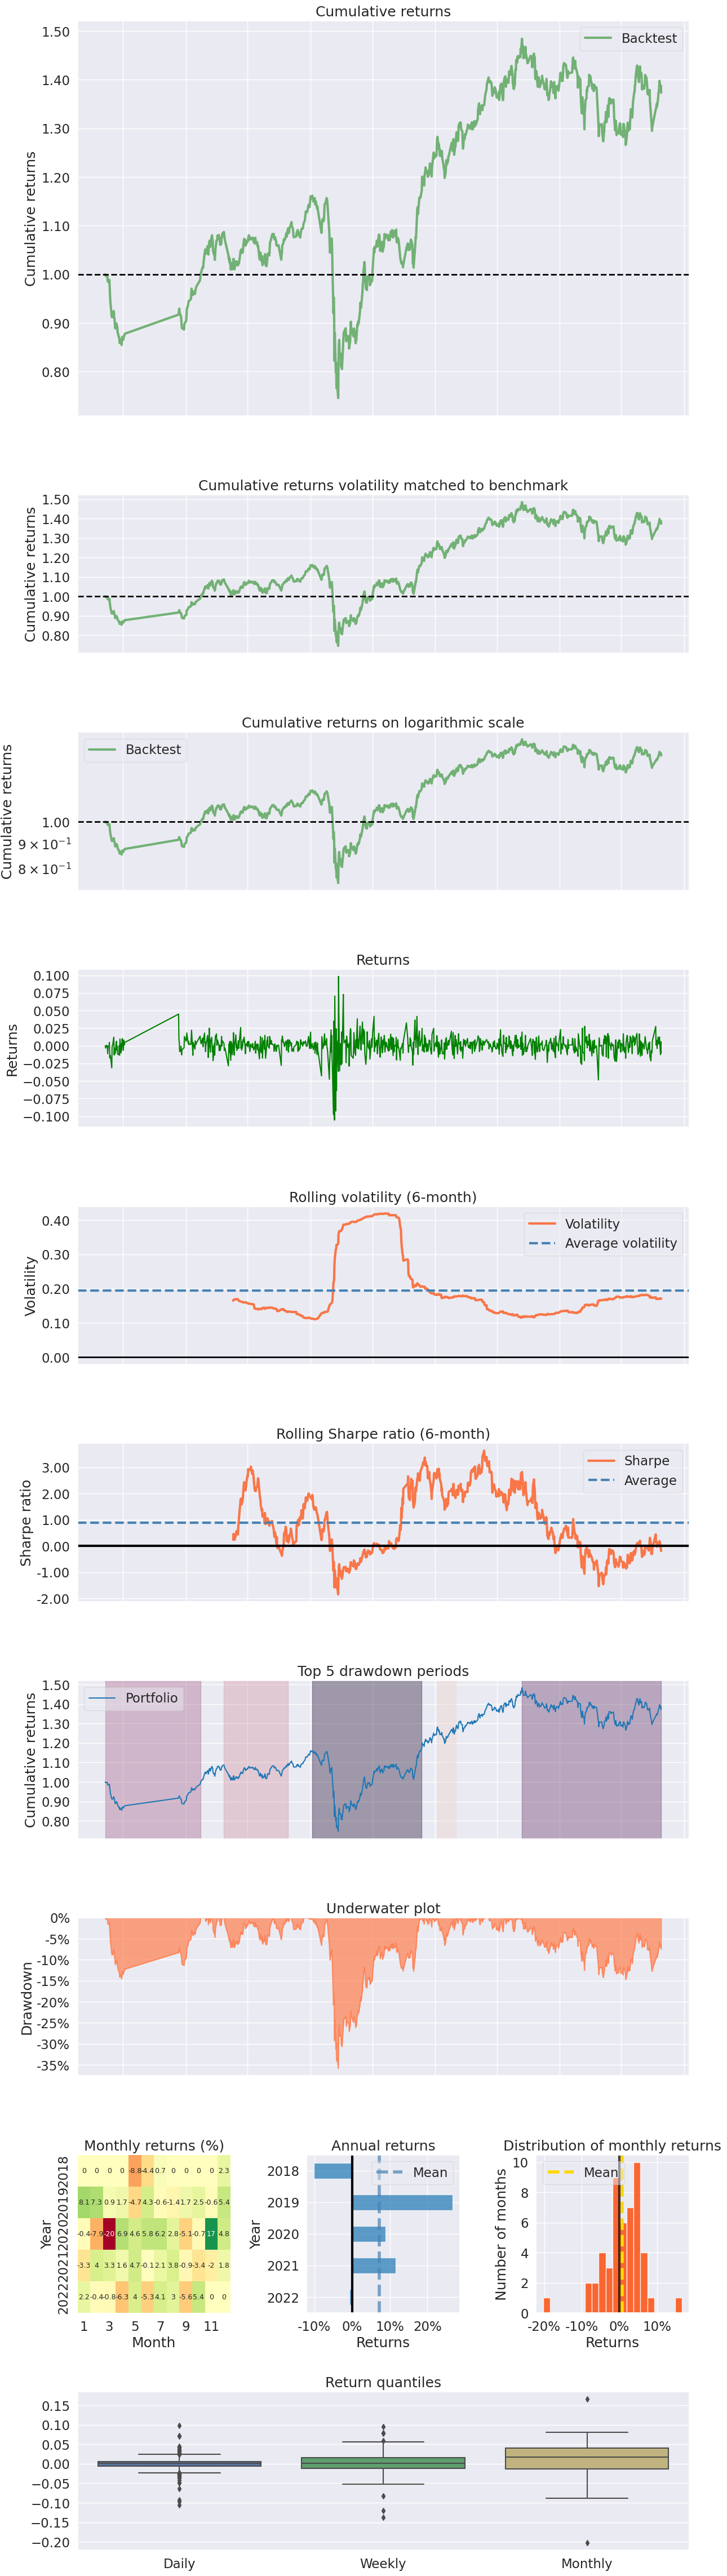

In [48]:
pf.create_full_tear_sheet(DRL_strat)

In [49]:
##baseline stats
#print("==============Get Baseline Stats===========")
#baseline_df = get_baseline(
#        ticker="^DJI", 
#        start = df_daily_return5.loc[0,'date'],
#        end = df_daily_return5.loc[len(df_daily_return5)-1,'date'])
#
#stats = backtest_stats(baseline_df, value_col_name = 'close')

In [50]:
df_comp = trade[['date','close','tic']]
df_comp.set_index('date',inplace=True)
res = df_comp.pivot(columns='tic', values='close')


# Asset weights
weight = res.shape[1]
wts = np.full(shape=weight, fill_value=1/weight).tolist()
ret_data = res.pct_change()

weighted_returns = (1/weight * ret_data)
weighted_returns.index= pd.to_datetime(weighted_returns.index)
weighted_returns

tic,600010.SS,600050.SS,600157.SS,600537.SS,600777.SS,600795.SS,601288.SS,601398.SS,601899.SS,603993.SS,...,MGLU3.SA,MSFT,PETR3.SA,PETR4.SA,RENT3.SA,SAN.MC,STLA.MI,T,VALE3.SA,iSP.MI
date,,,,,,,,,,,,,,,,,,,,,
2018-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-11,0.000000,-0.000559,-0.000628,-0.000246,-0.001214,-0.000087,0.000129,0.000292,0.000122,0.001358,...,-0.000194,-0.000054,0.000095,-0.000301,-0.000882,0.000146,0.000325,0.000322,0.000598,0.000120
2018-05-14,-0.000124,0.000308,-0.000644,-0.000124,0.000000,-0.000087,0.000192,0.000000,-0.000121,0.000429,...,-0.000115,0.000084,0.001036,0.000786,-0.000779,-0.000054,-0.000032,-0.000077,0.000779,0.000032
2018-05-15,0.000124,0.000652,0.000110,0.000063,-0.000680,0.000174,-0.000127,0.000082,-0.000244,0.000121,...,-0.000388,-0.000181,0.000630,0.000524,0.000566,-0.000177,-0.000134,-0.000078,0.000175,0.000222
2018-05-16,-0.000124,-0.000424,0.000110,-0.000187,-0.000699,0.000173,-0.000446,-0.000369,-0.000616,-0.000450,...,0.001348,-0.000044,0.000582,0.000560,0.000379,-0.000631,-0.000159,0.000164,0.000572,-0.000614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20,0.000000,0.000222,0.000000,-0.001477,0.000488,-0.000540,0.000088,0.000058,-0.000221,-0.000174,...,-0.000597,-0.000035,0.000671,0.000741,-0.000607,0.000323,0.000397,0.001931,0.000320,0.000522
2022-10-21,-0.000134,0.000220,-0.000152,-0.000268,-0.000287,0.001214,0.000088,0.000000,0.000255,-0.000059,...,0.000367,0.000632,0.000852,0.000857,0.000241,-0.000098,-0.000190,0.000538,0.000732,-0.000019
2022-10-24,-0.000541,-0.000581,-0.000152,-0.001006,-0.000388,-0.000684,-0.000087,0.000057,0.000032,-0.000646,...,-0.000422,0.000530,-0.002472,-0.002300,-0.000147,0.000621,0.000765,0.000599,-0.000742,0.000386


In [51]:
ptf_return= (weighted_returns.sum(axis=1,skipna=False))
ptf_return.name= 'Portfolio Returns'
ptf_return.index=DRL_strat.index

<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1125, 8)


Start date,2018-05-10
End date,2022-10-26
Total months,42
,Backtest
Annual return,9.362%
Cumulative returns,37.321%
Annual volatility,21.038%
Sharpe ratio,0.53
Calmar ratio,0.26
Stability,0.69
Max drawdown,-35.782%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.78,2020-01-07,2020-03-23,2020-11-23,230
1,14.71,2021-09-13,2022-07-14,NaT,NaN
2,14.54,2018-05-10,2018-06-27,2019-02-14,201
3,7.10,2019-04-23,2019-05-13,2019-10-28,135
4,6.59,2021-01-08,2021-01-29,2021-03-04,40


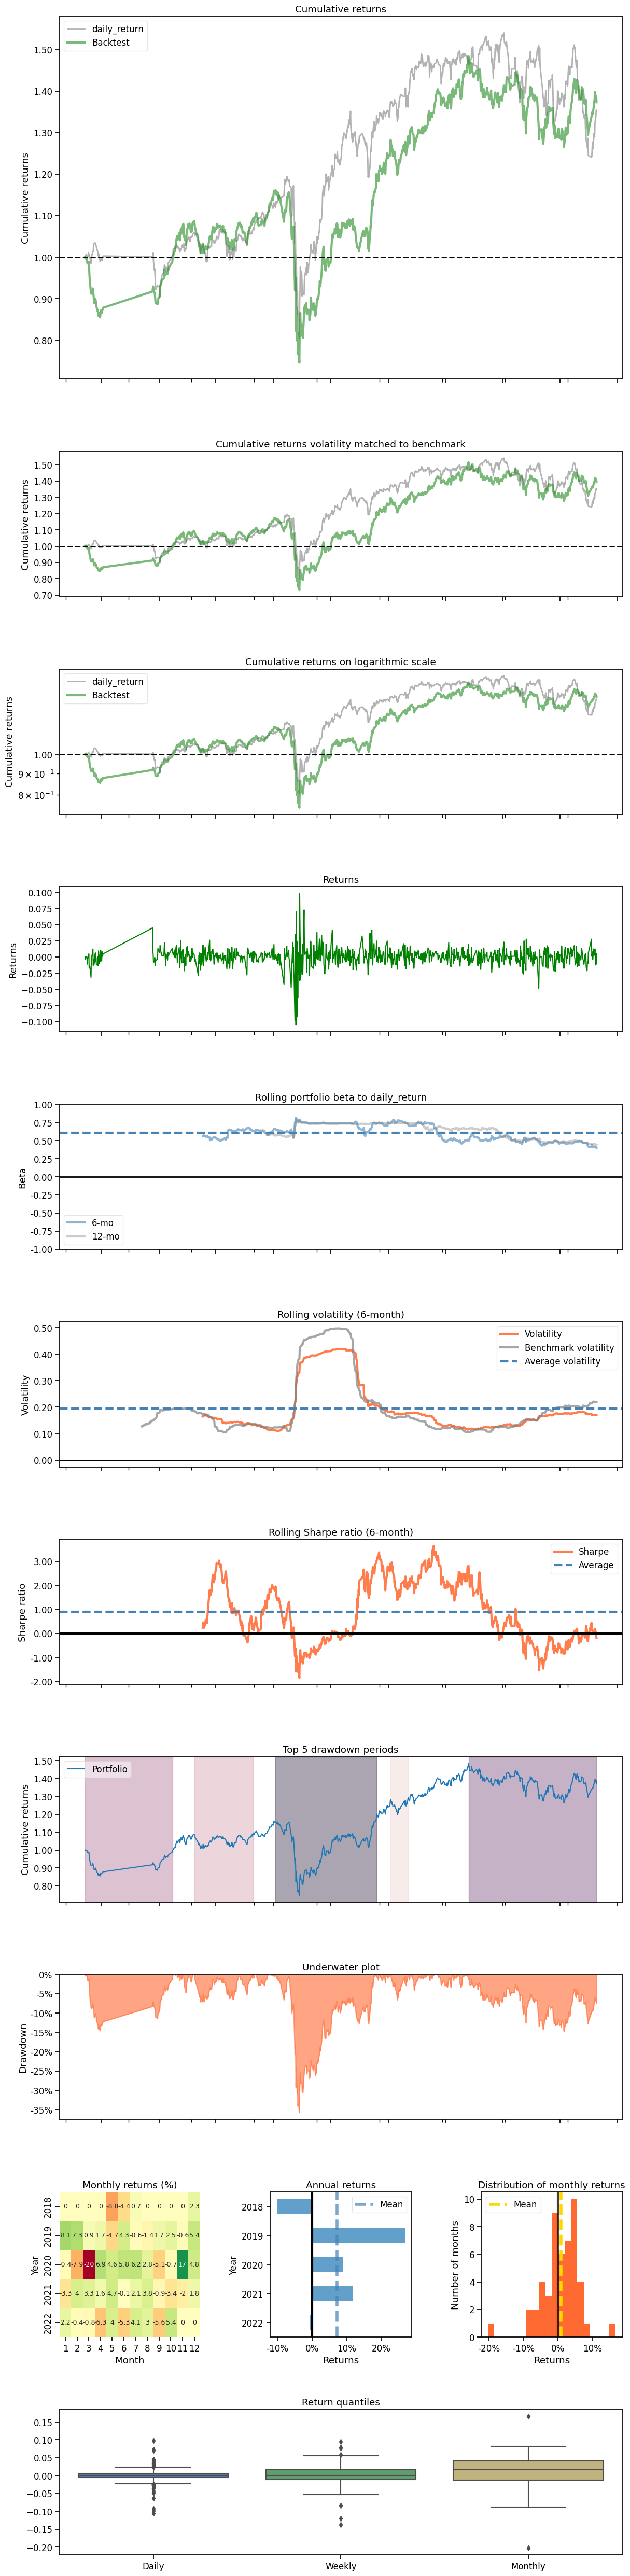

In [52]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return5.loc[0,'date'], end='2022-10-27'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

Start date,2018-05-10
End date,2022-10-26
Total months,42
,Backtest
Annual return,9.362%
Cumulative returns,37.321%
Annual volatility,21.038%
Sharpe ratio,0.53
Calmar ratio,0.26
Stability,0.69
Max drawdown,-35.782%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.78,2020-01-07,2020-03-23,2020-11-23,230
1,14.71,2021-09-13,2022-07-14,NaT,NaN
2,14.54,2018-05-10,2018-06-27,2019-02-14,201
3,7.10,2019-04-23,2019-05-13,2019-10-28,135
4,6.59,2021-01-08,2021-01-29,2021-03-04,40


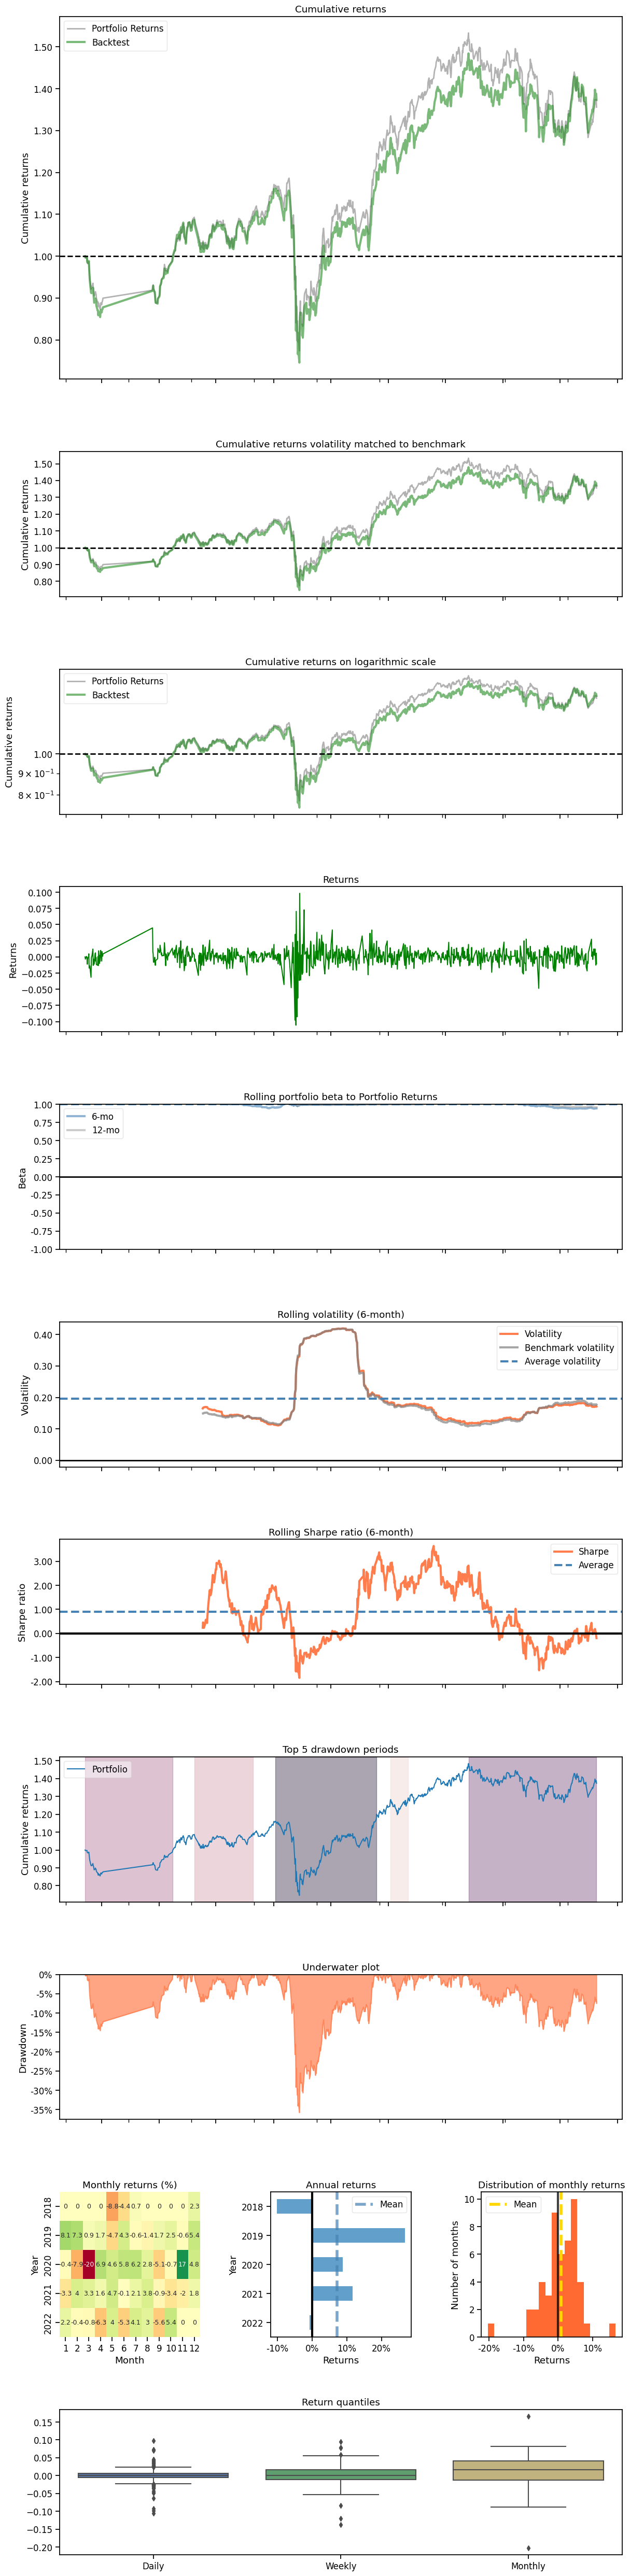

In [53]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=ptf_return, set_context=False)

## Min-Variance Portfolio Allocation

In [54]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [55]:
#calculate_portfolio_minimum_variance
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = trade[trade.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = trade[trade.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [56]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [57]:
#min_var_distribution = pd.DataFrame({'Ativo': stock_list, 'Peso': weight_list})
#min_var_distribution.set_index('Ativo',inplace= True)
#min_var_distribution[min_var_distribution>0].dropna().plot(y = 'Peso', kind= 'pie', figsize =(20,20))

In [58]:
#min_var_ptf= (min_var_returns.sum(axis=1,skipna=False))
#min_var_ptf.name= 'Min Var PTF Returns'
#min_var_ptf.index=DRL_strat.index

In [59]:
#with pyfolio.plotting.plotting_context(font_scale=1.1):pyfolio.create_full_tear_sheet(returns = DRL_strat,benchmark_rets=min_var_ptf, set_context=False)

In [60]:
#with pyfolio.plotting.plotting_context(font_scale=1.1):pyfolio.create_full_tear_sheet(returns = min_var_ptf,benchmark_rets=DRL_strat, set_context=False)

In [61]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c
sac_cumpod = (df_daily_return.daily_return+1).cumprod()-1
ddpg_cumpod  = (df_daily_return2.daily_return+1).cumprod()-1
ppo_cumpod  = (df_daily_return3.daily_return+1).cumprod()-1
a2c_cumpod   = (df_daily_return4.daily_return+1).cumprod()-1
td3_cumpod = (df_daily_return5.daily_return+1).cumprod()-1


In [62]:
#min_var_cumpod =(portfolio.account_value.pct_change().fillna(0)+1).cumprod()-1
#min_var_cumpod =(min_var_ptf.fillna(0)+1).cumprod()-1

In [63]:
dji_cumpod =(baseline_returns.fillna(0)+1).cumprod()-1

In [64]:
ptf_cumpod =(ptf_return.fillna(0)+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [65]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [66]:
time_ind = pd.Series(df_daily_return.date)

In [67]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c


trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C')
trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
trace3_portfolio = go.Scatter(x = time_ind, y = ptf_cumpod, mode = 'lines', name = 'Portfolio Buy & Hold')
trace4_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
trace5_portfolio = go.Scatter(x = time_ind, y = sac_cumpod, mode = 'lines', name = 'SAC')
trace6_portfolio = go.Scatter(x = time_ind, y = ppo_cumpod, mode = 'lines', name = 'PPO')
trace7_portfolio = go.Scatter(x = time_ind, y = td3_cumpod, mode = 'lines', name = 'TD3')

In [68]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)
fig.add_trace(trace3_portfolio)
fig.add_trace(trace4_portfolio)
fig.add_trace(trace5_portfolio)
fig.add_trace(trace6_portfolio)
fig.add_trace(trace7_portfolio)




fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="arial",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.85,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    #paper_bgcolor='rgba(1,1,0,0)',
    #paper_bgcolor='rgb(255,1,0)',
    #plot_bgcolor='rgba(1, 1, 0, 0)',
    xaxis_title="Data",
    yaxis_title="Retorno Acumulado",

    xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()

In [69]:
sac_cumpod

0      0.000000
1     -0.003338
2     -0.002924
3     -0.002222
4     -0.002513
         ...   
888    0.380539
889    0.397576
890    0.379887
891    0.387845
892    0.373205
Name: daily_return, Length: 893, dtype: float64